In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import smtplib
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from requests_html import HTMLSession
import sys, os
import io
import quandl as quandl 
from hurst import compute_Hc
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

In [3]:
final_df = pd.DataFrame()
start_date = '2006-01-01'
end_date = '2020-12-31'
api_string="44ErNV5zLdE6K7QpDWff"

def get_data(stock_code):
    start_time = datetime(2006, 1, 1, 0, 0) 
#     end_time = datetime.today()
    end_time = datetime(2020, 12, 31, 0, 0) 
    day_type = '1d'

    df = yf.download(stock_code,start=start_time,end=end_time,interval=day_type)            
    df = df.fillna(method='ffill')
    return df

# 1) Portfoilo DF

Purpose - To prevent return of more than -10%

Observation 
- When things go south, transfer more assets to US 5Y Treasury Futures (Low Risk, Medium Reward)- 
- Commodity Return is bad - Only have position when you are super confident (High Risk, Low Reward)
- World index - Go in if it is possible (Medium Risk, High Reward)

In [4]:
portfoilo_data = pd.read_excel('DATA INPUTS 2001 - 2021.xlsx')
portfoilo_data = portfoilo_data.set_index('Dates')
portfoilo_data = portfoilo_data.reindex(index=portfoilo_data.index[::-1])

portfoilo_data = portfoilo_data.resample('1m').mean()

portfoilo_data['MSCI World Index %'] = portfoilo_data['MSCI World Index'].pct_change()
portfoilo_data['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index'].pct_change()
portfoilo_data['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures'].pct_change()
portfoilo_data['Combination Return %'] = portfoilo_data['MSCI World Index %'] * 0.5 + portfoilo_data['Goldman Commodity Index %'] * 0.35 + portfoilo_data['US 5Y Treasury Futures %'] * 0.15

portfoilo_data['MSCI World Index Overall Return'] = portfoilo_data['MSCI World Index'].pct_change().cumsum()
portfoilo_data['Goldman Commodity Index Overall Return'] = portfoilo_data['Goldman Commodity Index'].pct_change().cumsum()
portfoilo_data['US 5Y Treasury Futures Overall Return'] = portfoilo_data['US 5Y Treasury Futures'].pct_change().cumsum()
portfoilo_data['Combination Overall Return'] = portfoilo_data['Combination Return %'].cumsum()

portfoilo_data['Combination Monthly Max Drawdown'] = portfoilo_data['Combination Overall Return'].rolling(30, min_periods=1).min()
portfoilo_data['Combination Monthly Max Drawdown Prediction'] = portfoilo_data['Combination Monthly Max Drawdown'].shift(-1)
portfoilo_data['Combination Return Prediction'] = portfoilo_data['Combination Overall Return'].shift(-1)

portfoilo_data = portfoilo_data[(portfoilo_data.index > '2006-01-01') &
                                (portfoilo_data.index < '2020-12-31')]

final_df['MSCI World Index %'] = portfoilo_data['MSCI World Index %']
final_df['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index %']
final_df['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures %']
final_df['Combination Return %'] = portfoilo_data['Combination Overall Return']
final_df['Combination Return Prediction'] = portfoilo_data['Combination Return Prediction'] 
final_df['Combination Max Drawdown Monthly'] = portfoilo_data['Combination Monthly Max Drawdown'] 
final_df['Combination Max Drawdown Prediction'] = portfoilo_data['Combination Monthly Max Drawdown Prediction'] 

portfoilo_figure = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index','Goldman Commodity Index','US 5Y Treasury Futures'], title='Portfoilo Value')
portfoilo_figure.update_layout(hovermode="x")
portfoilo_figure.show()

portfoilo_figure2 = px.line(portfoilo_data, x=portfoilo_data.index, y=['Combination Monthly Max Drawdown','Combination Overall Return'], title='Portfoilo Overall Return')
portfoilo_figure2.update_layout(hovermode="x")
portfoilo_figure2.show()

portfoilo_figure3 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index Overall Return','Goldman Commodity Index Overall Return','US 5Y Treasury Futures Overall Return'], title='Portfoilo Overall Return')
portfoilo_figure3.update_layout(hovermode="x")
portfoilo_figure3.show()

portfoilo_figure4 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index %','Goldman Commodity Index %','US 5Y Treasury Futures %','Combination Return %'], title='Portfoilo Monthly Return')
portfoilo_figure4.update_layout(hovermode="x")
portfoilo_figure4.show()

In [5]:
portfoilo_data

MSCI World Index  Goldman Commodity Index  US 5Y Treasury Futures  \
Dates                                                                           
2006-01-31       1297.709545               441.290673               79.632102   
2006-02-28       1301.192500               422.168160               78.560937   
2006-03-31       1323.397391               427.572548               78.172554   
2006-04-30       1354.021500               469.792870               77.500000   
2006-05-31       1354.889565               477.915287               77.227582   
...                      ...                      ...                     ...   
2020-07-31       2279.734783               337.972287              125.881114   
2020-08-31       2391.876190               353.558795              125.962426   
2020-09-30       2378.961818               347.966127              125.976918   
2020-10-31       2403.843636               354.709005              125.714844   
2020-11-30       2517.557619               369.202471              125.505208   

            MSCI World Index %  Goldman Commodity Index %  \
Dates                                                       
2006-01-31            0.029367                   0.014476   
2006-02-28            0.002684                  -0.043333   
2006-03-31            0.017065                   0.012802   
2006-04-30            0.023141                   0.098744   
2006-05-31            0.000641                   0.017289   
...                        ...                        ...   
2020-07-31            0.031888                   0.053329   
2020-08-31            0.049191                   0.046118   
2020-09-30           -0.005399                  -0.015818   
2020-10-31            0.010459                   0.019378   
2020-11-30            0.047305                   0.040860   

            US 5Y Treasury Futures %  Combination Return %  \
Dates                                                        
2006-01-31                  0.003113              0.020217   
2006-02-28                 -0.013451             -0.015842   
2006-03-31                 -0.004944              0.012271   
2006-04-30                 -0.008603              0.044840   
2006-05-31                 -0.003515              0.005845   
...                              ...                   ...   
2020-07-31                  0.002926              0.035048   
2020-08-31                  0.000646              0.040833   
2020-09-30                  0.000115             -0.008219   
2020-10-31                 -0.002080              0.011700   
2020-11-30                 -0.001668              0.037703   

            MSCI World Index Overall Return  \
Dates                                         
2006-01-31                         0.180154   
2006-02-28                         0.182838   
2006-03-31                         0.199903   
2006-04-30                         0.223044   
2006-05-31                         0.223685   
...                                     ...   
2020-07-31                         0.898054   
2020-08-31                         0.947245   
2020-09-30                         0.941846   
2020-10-31                         0.952305   
2020-11-30                         0.999610   

            Goldman Commodity Index Overall Return  \
Dates                                                
2006-01-31                                0.766827   
2006-02-28                                0.723494   
2006-03-31                                0.736296   
2006-04-30                                0.835040   
2006-05-31                                0.852329   
...                                            ...   
2020-07-31                                0.838814   
2020-08-31                                0.884932   
2020-09-30                                0.869113   
2020-10-31                                0.888491   
2020-11-30                                0.929351   

            US 5Y Treasury Futures Overall

# 2) Risk Indicator

## 2.1) Gold

In [6]:
gold_data = pd.read_csv('XAU_USD Historical Data.csv')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.set_index('Date').sort_index()
# gold_data = gold_data.reindex(index=gold_data.index[::-1])
gold_data['Price'] = pd.to_numeric(gold_data['Price'].str.replace(',',''))

gold_data = gold_data.resample('1m').mean()

gold_data['percent change'] = gold_data['Price'].pct_change()
gold_data['Overall Return'] = gold_data['percent change'].cumsum()

final_df['Gold percent change'] = gold_data['percent change'] 
# display(gold_data.head())

gold_figure3 = px.line(gold_data, x=gold_data.index, y="Overall Return", title='Overall Return')
gold_figure3.update_layout(hovermode="x")
gold_figure3.show()

gold_figure4 = px.line(gold_data, x=gold_data.index, y="percent change", title='Monthly Return')
gold_figure4.update_layout(hovermode="x")
gold_figure4.show()


## 2.2) VIX

In [7]:
VIX_data = get_data('^VIX')
VIX_data = VIX_data.resample('1m').mean()
                                  
final_df['VIX'] = VIX_data['Adj Close']

# display(VIX_data.head())
                                      
vix_figure = px.line(VIX_data, x=VIX_data.index, y="Adj Close", title='VIX Value')
vix_figure.update_layout(hovermode="x")
vix_figure.show()


[*********************100%***********************]  1 of 1 completed


## 2.3) 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity

https://ycharts.com/indicators/10_2_year_treasury_yield_spread

In [8]:
Treasury_Data = pd.read_excel("T10Y2Y.xls")
Treasury_Data = Treasury_Data.set_index('observation_date')

Treasury_Data = Treasury_Data.resample('1m').mean()

Treasury_Data = Treasury_Data[(Treasury_Data.index > '2006-01-01') &
                              (Treasury_Data.index < '2020-12-31')]

# display(Treasury_Data)

treasury_figure = px.line(Treasury_Data, x=Treasury_Data.index, y=["T10Y2Y"], title='Treasury Value')
treasury_figure.update_layout(hovermode="x")
treasury_figure.show()

final_df['T10Y2Y'] = Treasury_Data['T10Y2Y']

## 2.4)  United States Misery Index

In [9]:
misery_data = quandl.get("USMISERY/INDEX", api_key=api_string, start_date=start_date, end_date=end_date)

In [10]:
misery_data.index = pd.to_datetime(misery_data.index)

# display(misery_data.head())

final_df['Misery Index'] = misery_data['Misery Index']

misery_figure = px.line(misery_data, x=misery_data.index, y="Misery Index", title='Misery Value')
misery_figure.update_layout(hovermode="x")
misery_figure.show()

## 2.5) US High Yield Corporate Bond Index OAS

In [11]:
corporate_data_source = quandl.get("ML/HYOAS", api_key = api_string, start_date=start_date, end_date=end_date)

In [12]:
# The risk-free rate we will use is the one-year Treasury bill rate
# Source: https://fred.stlouisfed.org/series/DGS1
rf = pd.read_excel('DGS1.xls')
rf = rf.set_index('observation_date')
rf = rf[(rf.index > '2006-01-01') & (rf.index < '2020-12-31')]

corporate_data = corporate_data_source.copy()
corporate_data['rf'] = rf
corporate_data['corporate - rf'] = corporate_data['BAMLH0A0HYM2'] - corporate_data['rf']

corporate_data = corporate_data.resample('1m').mean()
final_df['corporate - rf'] = corporate_data['corporate - rf']

corporate_figure = px.line(corporate_data, x=corporate_data.index, y=["corporate - rf"], title='Corporate minus RF Value')
corporate_figure.update_layout(hovermode="x")
corporate_figure.show()

# 2.6) Oil

In [13]:
oil_data = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
oil_data['Date'] = pd.to_datetime(oil_data['Date'])
oil_data = oil_data.set_index('Date').sort_index()
# oil_data = oil_data.reindex(index=oil_data.index[::-1])
# oil_data['Price'] = pd.to_numeric(oil_data['Price'].str.replace(',',''))

oil_data = oil_data.resample('1m').mean()

oil_data = oil_data[(oil_data.index > '2006-01-01') &
                    (oil_data.index < '2020-12-31')]

oil_data['percent change'] = oil_data['Price'].pct_change()
oil_data['Overall Return'] = oil_data['percent change'].cumsum()

final_df['Oil percent change'] = oil_data['percent change'] 
# display(oil_data.head())

gold_figure = px.line(oil_data, x=oil_data.index, y=["Price"], title='Gold Value')
gold_figure.update_layout(hovermode="x")
gold_figure.show()

gold_figure3 = px.line(oil_data, x=oil_data.index, y="Overall Return", title='Overall Return')
gold_figure3.update_layout(hovermode="x")
gold_figure3.show()

gold_figure4 = px.line(oil_data, x=oil_data.index, y="percent change", title='Monthly Return')
gold_figure4.update_layout(hovermode="x")
gold_figure4.show()
oil_data

Price     Open     High      Low  percent change  Overall Return
Date                                                                          
2006-01-31  65.9220  65.2620  67.3000  63.4540             NaN             NaN
2006-02-28  62.0750  62.9375  63.9600  59.6875       -0.058357       -0.058357
2006-03-31  63.4050  62.7375  64.9675  60.4700        0.021426       -0.036931
2006-04-30  70.7900  70.0500  72.6980  68.3820        0.116473        0.079542
2006-05-31  71.0675  70.4450  72.7100  68.3925        0.003920        0.083462
...             ...      ...      ...      ...             ...             ...
2020-07-31  40.6750  40.6400  41.6675  39.0400        0.048663        0.511325
2020-08-31  41.6620  41.9040  43.3680  40.7580        0.024266        0.535591
2020-09-30  38.9350  39.4625  40.7875  37.0600       -0.065455        0.470135
2020-10-31  39.2800  39.4450  41.0725  37.6325        0.008861        0.478996
2020-11-30  42.2420  40.1100  43.5620  39.4320        0.075407        0.554404

[179 rows x 6 columns]

# 3) Combination Data 2006-2020 Overview

In [14]:
final_df.to_csv('final_df.csv')

In [15]:
final_df.columns

Index(['MSCI World Index %', 'Goldman Commodity Index %',
       'US 5Y Treasury Futures %', 'Combination Return %',
       'Combination Return Prediction', 'Combination Max Drawdown Monthly',
       'Combination Max Drawdown Prediction', 'Gold percent change', 'VIX',
       'T10Y2Y', 'Misery Index', 'corporate - rf', 'Oil percent change'],
      dtype='object')

In [16]:
fig1 = px.imshow(final_df.corr(), 
                 labels=dict(color="Correlation"), 
                 width=1000, height=800,
                 color_continuous_scale=px.colors.sequential.matter)
fig1.show()

In [17]:
final_df.to_csv('final_df.csv')
final_df

MSCI World Index %  Goldman Commodity Index %  \
Dates                                                       
2006-01-31            0.029367                   0.014476   
2006-02-28            0.002684                  -0.043333   
2006-03-31            0.017065                   0.012802   
2006-04-30            0.023141                   0.098744   
2006-05-31            0.000641                   0.017289   
...                        ...                        ...   
2020-07-31            0.031888                   0.053329   
2020-08-31            0.049191                   0.046118   
2020-09-30           -0.005399                  -0.015818   
2020-10-31            0.010459                   0.019378   
2020-11-30            0.047305                   0.040860   

            US 5Y Treasury Futures %  Combination Return %  \
Dates                                                        
2006-01-31                  0.003113              0.398820   
2006-02-28                 -0.013451              0.382977   
2006-03-31                 -0.004944              0.395249   
2006-04-30                 -0.008603              0.440089   
2006-05-31                 -0.003515              0.445933   
...                              ...                   ...   
2020-07-31                  0.002926              0.853049   
2020-08-31                  0.000646              0.893882   
2020-09-30                  0.000115              0.885663   
2020-10-31                 -0.002080              0.897363   
2020-11-30                 -0.001668              0.935067   

            Combination Return Prediction  Combination Max Drawdown Monthly  \
Dates                                                                         
2006-01-31                       0.382977                         -0.027712   
2006-02-28                       0.395249                         -0.023687   
2006-03-31                       0.440089                          0.013460   
2006-04-30                       0.445933                          0.024528   
2006-05-31                       0.415674                          0.066829   
...                                   ...                               ...   
2020-07-31                       0.893882                          0.675593   
2020-08-31                       0.885663                          0.675593   
2020-09-30                       0.897363                          0.675593   
2020-10-31                       0.935067                          0.675593   
2020-11-30                       0.987586                          0.675593   

            Combination Max Drawdown Prediction  Gold percent change  \
Dates                                                                  
2006-01-31                            -0.023687             0.083156   
2006-02-28                             0.013460             0.006329   
2006-03-31                             0.024528             0.005305   
2006-04-30                             0.066829             0.096059   
2006-05-31                             0.106780             0.100783   
...                                         ...                  ...   
2020-07-31                             0.675593             0.063718   
2020-08-31                             0.675593             0.066606   
2020-09-30                             0.675593            -0.023598   
2020-10-31                             0.675593            -0.012150   
2020-11-30                             0.675593            -0.018059   

                  VIX    T10Y2Y  Misery Index  corporate - rf  \
Dates                                                           
2006-01-31  12.036000  0.020500          8.69       -0.902000   
2006-02-28  12.471053 -0.099474          8.40       -1.347895   
2006-03-31  11.693913 -0.010000          8.06       -1.521739   
2006-04-30  11.847368  0.101579          8.25       -1.835789   
2006-05-31  14.454545  0.141818          8.77       -1.9

# 4) Correlation Over The Years

MSCI World Index % & Gold percent change
Pearsonr Correlation


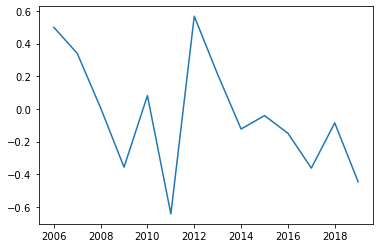

Spearman Correlation


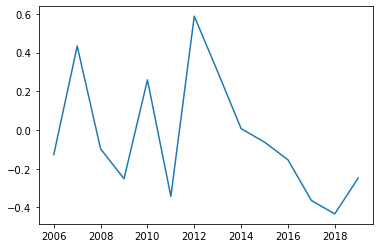

MSCI World Index % & Oil percent change
Pearsonr Correlation


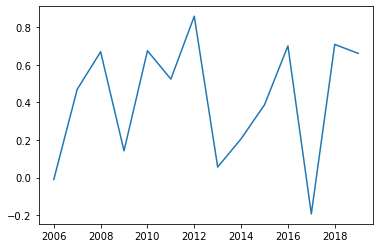

Spearman Correlation


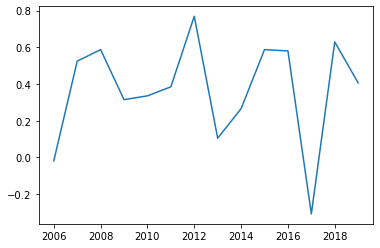

MSCI World Index % & VIX
Pearsonr Correlation


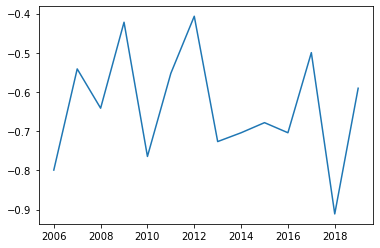

Spearman Correlation


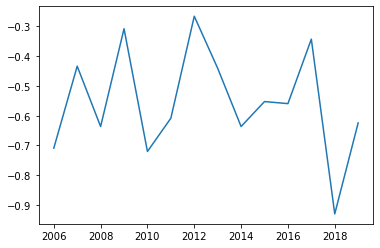

MSCI World Index % & Misery Index
Pearsonr Correlation


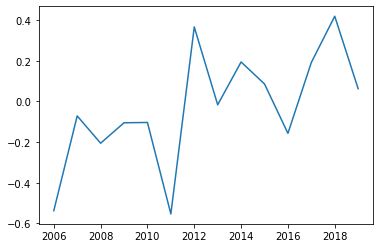

Spearman Correlation


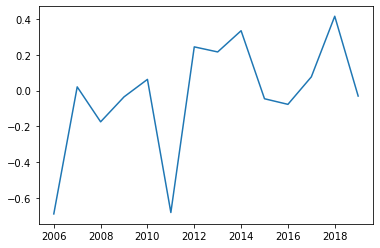

MSCI World Index % & T10Y2Y
Pearsonr Correlation


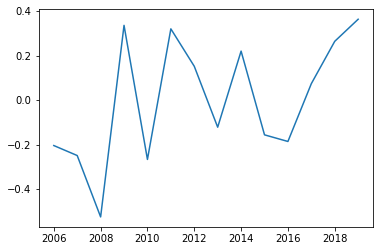

Spearman Correlation


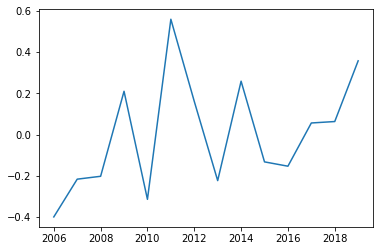

MSCI World Index % & corporate - rf
Pearsonr Correlation


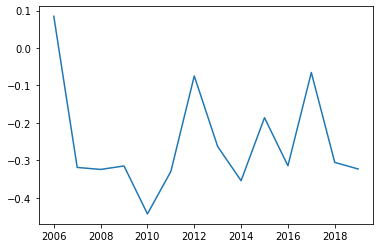

Spearman Correlation


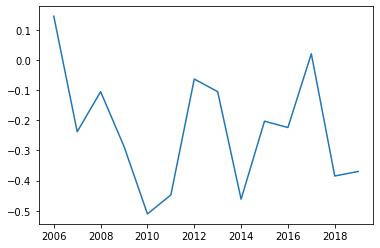

Goldman Commodity Index % & Gold percent change
Pearsonr Correlation


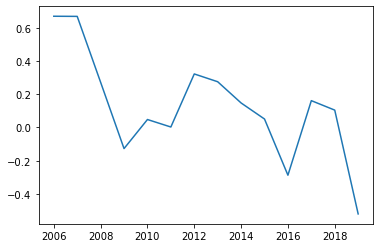

Spearman Correlation


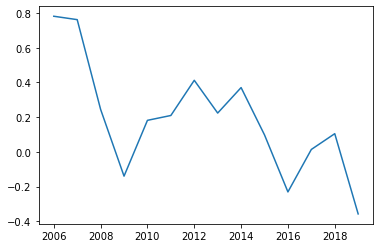

Goldman Commodity Index % & Oil percent change
Pearsonr Correlation


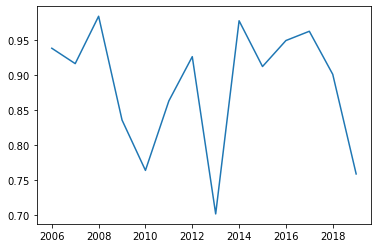

Spearman Correlation


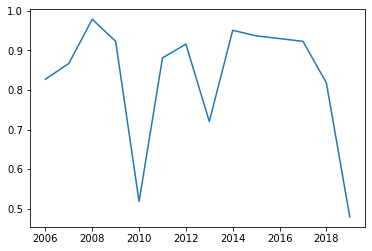

Goldman Commodity Index % & VIX
Pearsonr Correlation


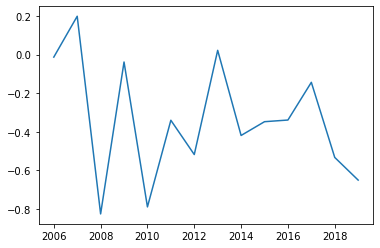

Spearman Correlation


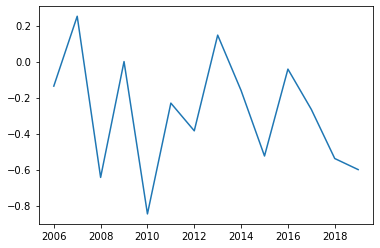

Goldman Commodity Index % & Misery Index
Pearsonr Correlation


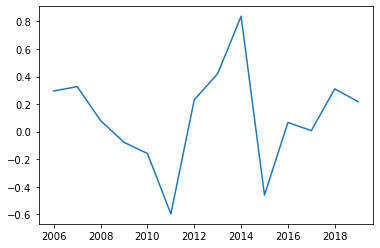

Spearman Correlation


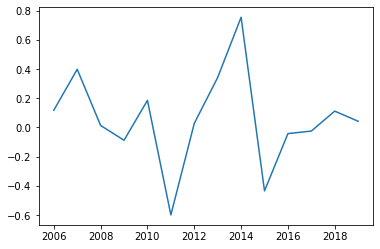

Goldman Commodity Index % & T10Y2Y
Pearsonr Correlation


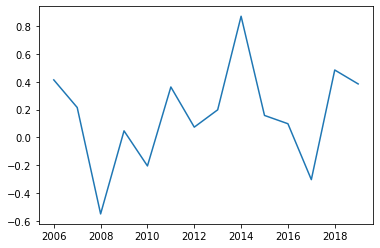

Spearman Correlation


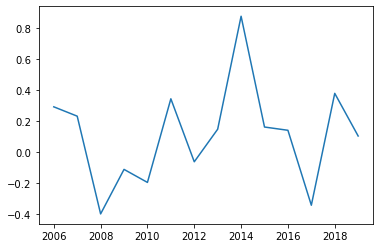

Goldman Commodity Index % & corporate - rf
Pearsonr Correlation


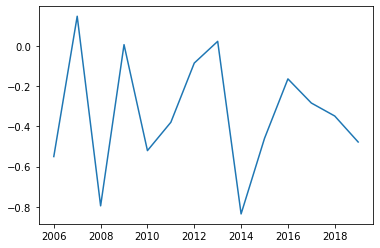

Spearman Correlation


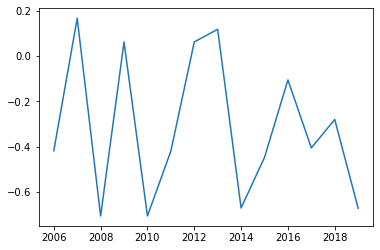

US 5Y Treasury Futures % & Gold percent change
Pearsonr Correlation


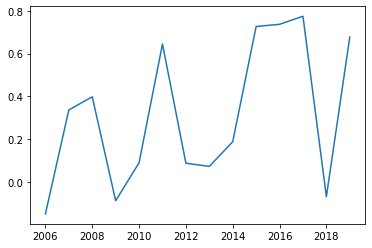

Spearman Correlation


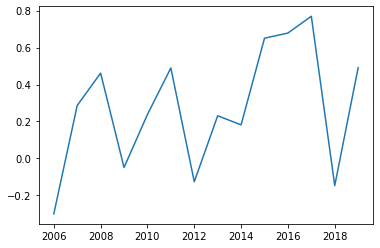

US 5Y Treasury Futures % & Oil percent change
Pearsonr Correlation


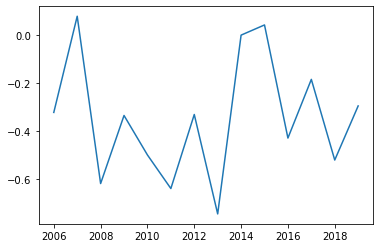

Spearman Correlation


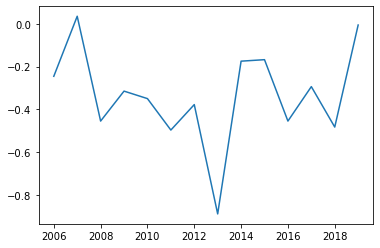

US 5Y Treasury Futures % & VIX
Pearsonr Correlation


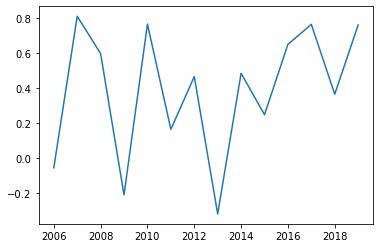

Spearman Correlation


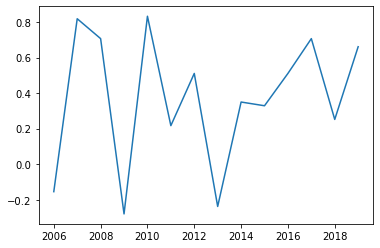

US 5Y Treasury Futures % & Misery Index
Pearsonr Correlation


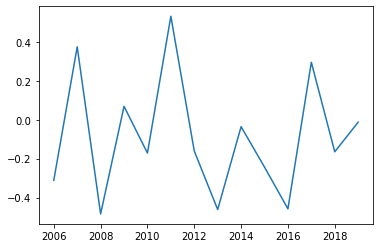

Spearman Correlation


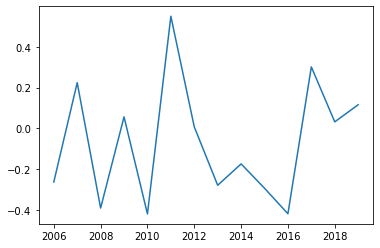

US 5Y Treasury Futures % & T10Y2Y
Pearsonr Correlation


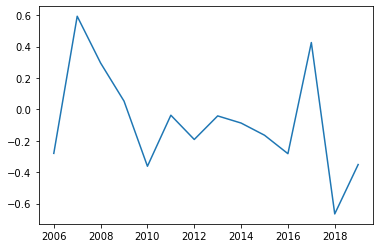

Spearman Correlation


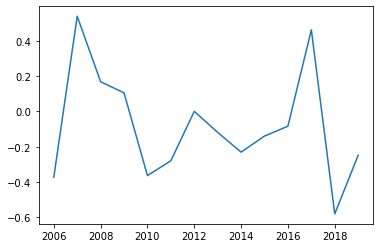

US 5Y Treasury Futures % & corporate - rf
Pearsonr Correlation


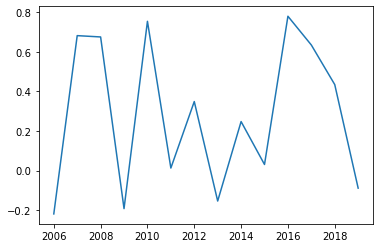

Spearman Correlation


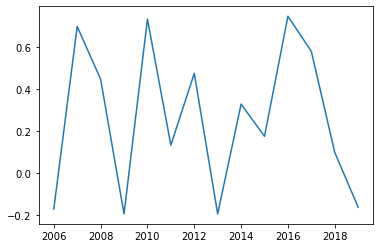

In [18]:
years = range(2006, 2020)
portfoilo = ['MSCI World Index %','Goldman Commodity Index %','US 5Y Treasury Futures %']
risk_indicator= ['Gold percent change','Oil percent change', 'VIX', 'Misery Index','T10Y2Y', 'corporate - rf']
           
for product in portfoilo:
    for risk in risk_indicator: 
        spearman_correlation_list = []
        pearsonr_correlation_list = []
        
        for single_year in years:
            resample_data_year = final_df[final_df.index.year == single_year].dropna().copy()
            resample_data_year.replace([np.inf, -np.inf], np.nan, inplace=True)
            resample_data_year = resample_data_year.dropna()
            
#             #Pearsonr - Check for linear relationship, same direction at constant rate
            pearsonr_data , _ = pearsonr(resample_data_year[product], resample_data_year[risk])
            pearsonr_correlation_list.append(pearsonr_data)
            
            #Spearman - Check for monotonic relationship, same direction different rate
            spearman_data , _ = spearmanr(resample_data_year[product], resample_data_year[risk])
            spearman_correlation_list.append(spearman_data)
                             
            #Chi-Square
#             table = [resample_data_year[product].values ** 2,
#                      resample_data_year[risk].values ** 2]
#             stat, p, dof, expected = chi2_contingency(table)
# #             print('dof=%d' % dof)
# #             print(expected)
#             # interpret test-statistic
#             prob = 0.95
#             critical = chi2.ppf(prob, dof)
#             print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
#             if abs(stat) >= critical:
#                 print('Dependent (reject H0)')
#             else:
#                 print('Independent (fail to reject H0)')
                
#         print(spearman_correlation_list)
#         print(pearsonr_correlation_list)
        
        print(product + ' & ' + risk)
        print('Pearsonr Correlation')
        plt.figure(0)
        plt.plot(years,pearsonr_correlation_list)
        plt.show()
        
        print('Spearman Correlation')
        plt.figure(1)
        plt.plot(years,spearman_correlation_list)
        plt.show()
        


# Regression`

In [19]:
#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
le = preprocessing.LabelEncoder()

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

#libraries for models
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from yellowbrick.regressor import AlphaSelection

from sklearn.linear_model import Lasso

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

In [20]:
final_df.columns

Index(['MSCI World Index %', 'Goldman Commodity Index %',
       'US 5Y Treasury Futures %', 'Combination Return %',
       'Combination Return Prediction', 'Combination Max Drawdown Monthly',
       'Combination Max Drawdown Prediction', 'Gold percent change', 'VIX',
       'T10Y2Y', 'Misery Index', 'corporate - rf', 'Oil percent change'],
      dtype='object')

In [21]:
ml_data = final_df
ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_data = ml_data.dropna()

prediction = ['Combination Return Prediction', 'Combination Max Drawdown Prediction',]
risk_indicator= ['Gold percent change', 'Oil percent change', 'VIX','Misery Index','T10Y2Y','corporate - rf']
             
feature_list_numerical =  ml_data[risk_indicator]
feature_list_target = ml_data[prediction[1]]

df = pd.concat([feature_list_numerical, feature_list_target], axis=1)
df

Gold percent change  Oil percent change        VIX  Misery Index  \
Dates                                                                          
2006-02-28             0.006329           -0.058357  12.471053          8.40   
2006-03-31             0.005305            0.021426  11.693913          8.06   
2006-04-30             0.096059            0.116473  11.847368          8.25   
2006-05-31             0.100783            0.003920  14.454545          8.77   
2006-06-30            -0.115003            0.007176  16.918636          8.92   
...                         ...                 ...        ...           ...   
2020-05-31             0.019149            0.671614  30.897000         13.42   
2020-08-31             0.066606            0.024266  22.889524          9.71   
2020-09-30            -0.023598           -0.065455  27.647619          9.27   
2020-10-31            -0.012150            0.008861  29.438636          8.08   
2020-11-30            -0.018059            0.075407  24.995500          7.87   

              T10Y2Y  corporate - rf  Combination Max Drawdown Prediction  
Dates                                                                      
2006-02-28 -0.099474       -1.347895                             0.013460  
2006-03-31 -0.010000       -1.521739                             0.024528  
2006-04-30  0.101579       -1.835789                             0.066829  
2006-05-31  0.141818       -1.980909                             0.106780  
2006-06-30 -0.015455       -1.874091                             0.109559  
...              ...             ...                                  ...  
2020-05-31  0.503500        7.174500                             0.675593  
2020-08-31  0.510476        4.993333                             0.675593  
2020-09-30  0.544762        5.138571                             0.675593  
2020-10-31  0.637619        4.919048                             0.675593  
2020-11-30  0.704211        4.426316                             0.675593  

[174 rows x 7 columns]

In [22]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

Gold percent change  Oil percent change       VIX  Misery Index  \
Dates                                                                         
2006-02-28            -0.012235           -0.572152 -0.756872      0.083919   
2006-03-31            -0.038290            0.184110 -0.841084     -0.067766   
2006-04-30             2.270180            1.085071 -0.824456      0.016999   
2006-05-31             2.390340            0.018173 -0.541936      0.248988   
2006-06-30            -3.098536            0.049039 -0.274921      0.315908   
...                         ...                 ...       ...           ...   
2020-05-31             0.313855            6.347267  1.239809      2.323507   
2020-08-31             1.521005            0.211028  0.372099      0.668354   
2020-09-30            -0.773479           -0.639439  0.887698      0.472055   
2020-10-31            -0.482303            0.065008  1.081777     -0.058843   
2020-11-30            -0.632606            0.695803  0.600308     -0.152531   

              T10Y2Y  corporate - rf  Combination Max Drawdown Prediction  
Dates                                                                      
2006-02-28 -1.602527       -1.527377                            -2.026773  
2006-03-31 -1.500617       -1.574025                            -1.974148  
2006-04-30 -1.373530       -1.658294                            -1.773030  
2006-05-31 -1.327697       -1.697234                            -1.583084  
2006-06-30 -1.506830       -1.668571                            -1.569872  
...              ...             ...                                  ...  
2020-05-31 -0.915744        0.759438                             1.121338  
2020-08-31 -0.907798        0.174165                             1.121338  
2020-09-30 -0.868747        0.213137                             1.121338  
2020-10-31 -0.762983        0.154232                             1.121338  
2020-11-30 -0.687136        0.022017                             1.121338  

[174 rows x 7 columns]

In [23]:
def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

## Model Implementation

1)Linear Regression

2)Ridge Regression

3)Lasso Regression

4)K-Neighbors Regressor

5)Random Forest Regressor

6)Bagging Regressor

7)Adaboost Regressor

8)XGBoost¶



# 1) Linear Regression

In [24]:
#fitting model
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

#calculating error/accuracy
y_test_1,y_pred_1=y_test,y_pred
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', LR.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [-0.8174195  -0.29880554 -0.01061511 -0.02710701 -0.07058342  0.02900625]
MSLE : 0.016534353334720534
Root MSLE : 0.12858597643102662
R2 Score : 0.3387354617461802 or 33.8735%


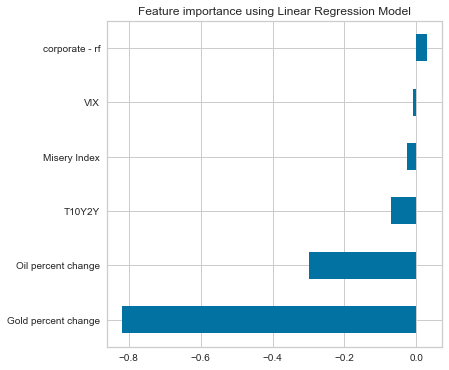

In [25]:
#Ploting feature importance graph
coef = pd.Series(LR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

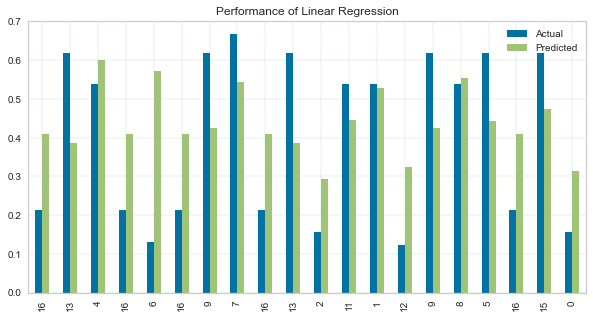

In [26]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(20, replace=True)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Linear Regression')
plt.savefig('Linear-Regression-Performance')
plt.show()

# 2) Ridge regression

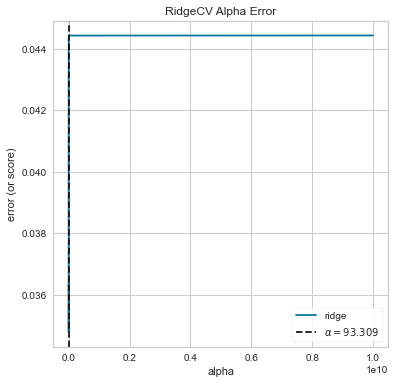

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [27]:
#predicting value of alpha

alphas = 10**np.linspace(10,-2,400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train,y_train)
visualizer.show()

In [28]:
#model object and fitting model
RR=Ridge(alpha=20.336,solver='auto')
RR.fit(X_train,y_train)
y_pred=RR.predict(X_test)

In [29]:
#model evaluation

y_test_2,y_pred_2=y_test,y_pred
r2_ridge=result(y_test_2,y_pred_2)
print("MSLE : {}".format(r2_ridge[0]))
print("Root MSLE : {}".format(r2_ridge[1]))
print("R2 Score : {} or {}%".format(r2_ridge[2],r2_ridge[3]))
accu['Ridge Regression']=r2_ridge

MSLE : 0.014525121704013091
Root MSLE : 0.12052021284420755
R2 Score : 0.42917240767572384 or 42.9172%


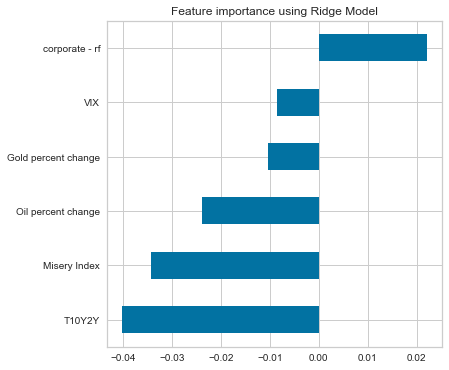

In [30]:
#Visualization of Feature Importance

coef = pd.Series(RR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")
plt.savefig('Ridge-Regression-Feature-Importance.jpg')
plt.show()

# 3) Lasso Regression

In [31]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [32]:
#model evaluation
y_test_3,y_pred_3=y_test,y_pred
r3_lasso=result(y_test_3,y_pred_3)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 0.016415238326762564
Root MSLE : 0.1281219666051164
R2 Score : 0.3443847747930957 or 34.4385%


# 4) KNN

In [33]:
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 0.08683763201858968
K = 2  , Root MSLE = 0.05796332633060647
K = 3  , Root MSLE = 0.06699032334679372
K = 4  , Root MSLE = 0.0639471887776328
K = 5  , Root MSLE = 0.059174791873979136
K = 6  , Root MSLE = 0.060802445649389754
K = 7  , Root MSLE = 0.06761542057257099
K = 8  , Root MSLE = 0.06655359120742405
K = 9  , Root MSLE = 0.06738167386055688


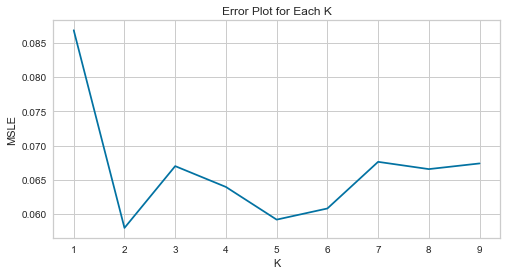

In [34]:
#plotting error
curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [35]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=5) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

In [36]:
#model evaluation
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 0.003501655993328747
Root MSLE : 0.059174791873979136
R2 Score : 0.869141820336519 or 86.9142%


In [37]:
accu.to_csv('errors.csv')

# 5) Random Forest

In [38]:
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [39]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf

MSLE : 0.002215939564795092
Root MSLE : 0.04707376726792845
R2 Score : 0.913881887205428 or 91.3882%


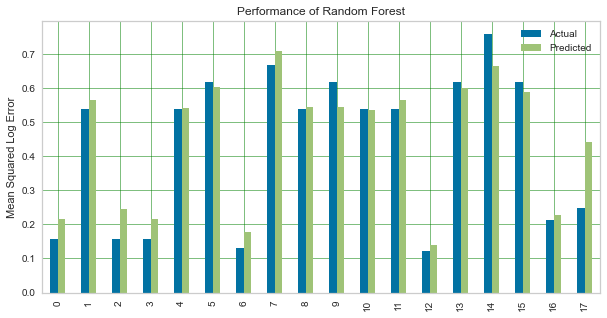

In [40]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

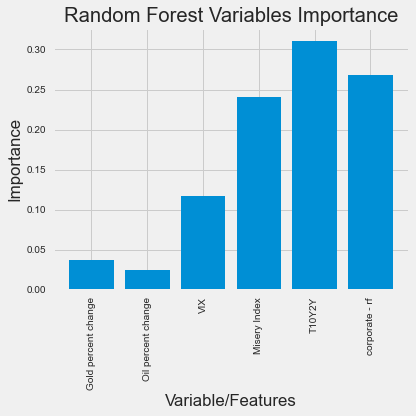

In [41]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

# 6) Bagging Regressor

In [42]:
#model implementation
baggReg=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),n_estimators=50, random_state=1,
                         max_samples=1.0, max_features=1.0, bootstrap=False, 
                         bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, verbose=0)
baggReg.fit(X_train,y_train)
y_pred=baggReg.predict(X_test)

In [43]:
#model evaluation
r6_br=result(y_test,y_pred)
print("MSLE : {}".format(r6_br[0]))
print("Root MSLE : {}".format(r6_br[1]))
print("R2 Score : {} or {}%".format(r6_br[2],r6_br[3]))

MSLE : 0.01796657559800604
Root MSLE : 0.13403945537790743
R2 Score : 0.2933334341543019 or 29.3333%


In [44]:
accu['Bagging Regressor']=r6_br
accu.to_csv('errors.csv')

# 7) Adaboost

In [45]:
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)

In [46]:
#model evaluation
r7_ab=result(y_test,y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 0.00031580293101441894
Root MSLE : 0.017770844971875113
R2 Score : 0.9822953200920156 or 98.2295%


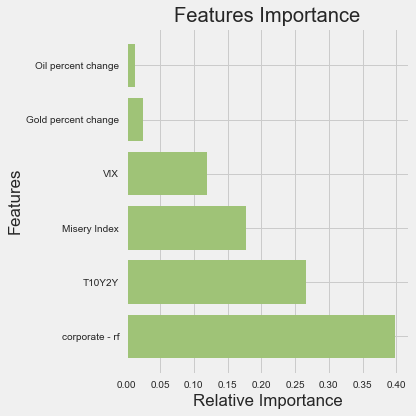

In [47]:
importances=ABR.feature_importances_
features=X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance2.jpg',dpi=60)
plt.show();

In [48]:
accu['AdaBoost Regressor']=r7_ab
accu.to_csv('errors.csv')

# 8) XGboost

In [49]:
#model implementation and fitting data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

y_test_1,y_pred_1=y_test,y_pred
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.019255393792871712
Root MSLE : 0.1387638057739543
R2 Score : 0.24388956619420477 or 24.389%


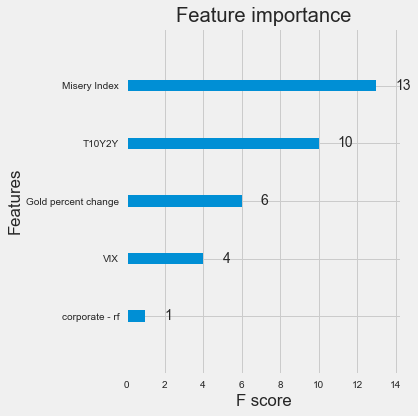

In [50]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

# Overall Result

In [51]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

Linear Regression  Ridge Regression  Lasso Regression        KNN  \
MSLE                  0.016534          0.014525          0.016415   0.003502   
Root MSLE             0.128586          0.120520          0.128122   0.059175   
R2 Score              0.338735          0.429172          0.344385   0.869142   
Accuracy(%)          33.873500         42.917200         34.438500  86.914200   

             RandomForest Regressor  Bagging Regressor  AdaBoost Regressor  
MSLE                       0.002216           0.017967            0.000316  
Root MSLE                  0.047074           0.134039            0.017771  
R2 Score                   0.913882           0.293333            0.982295  
Accuracy(%)               91.388200          29.333300           98.229500

In [52]:
model_accuracy=accu.loc['Accuracy(%)']

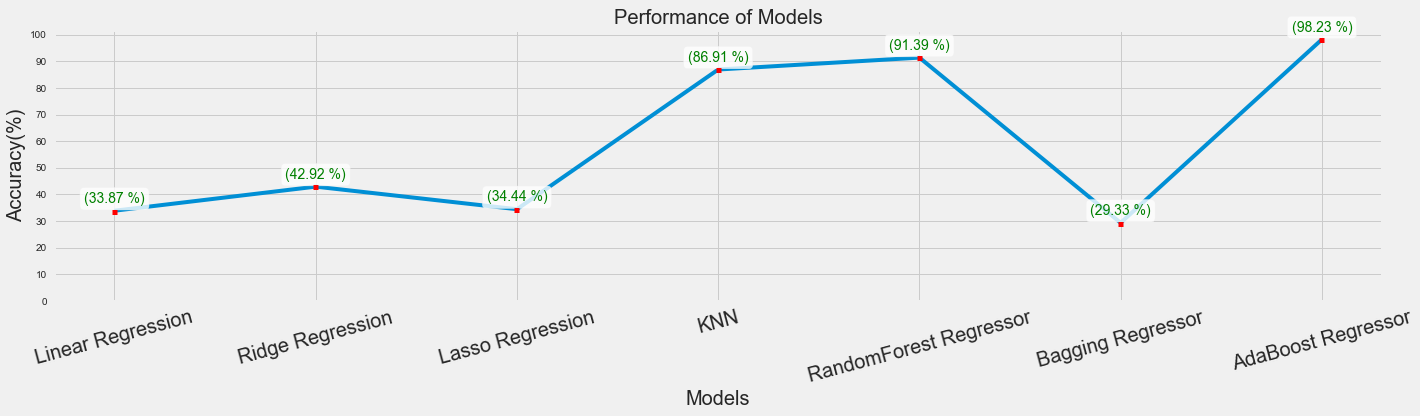

In [53]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (15))
plt.xlabel("Models",fontsize=20)
plt.ylabel("Accuracy(%)",fontsize=20)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show();

# 4) Making Prediction Based On Existing Data

In [54]:
feature_list =  final_df[risk_indicator].fillna(method='bfill')
feature_list

Gold percent change  Oil percent change        VIX  Misery Index  \
Dates                                                                          
2006-01-31             0.083156           -0.058357  12.036000          8.69   
2006-02-28             0.006329           -0.058357  12.471053          8.40   
2006-03-31             0.005305            0.021426  11.693913          8.06   
2006-04-30             0.096059            0.116473  11.847368          8.25   
2006-05-31             0.100783            0.003920  14.454545          8.77   
...                         ...                 ...        ...           ...   
2020-07-31             0.063718            0.048663  26.840455          9.71   
2020-08-31             0.066606            0.024266  22.889524          9.71   
2020-09-30            -0.023598           -0.065455  27.647619          9.27   
2020-10-31            -0.012150            0.008861  29.438636          8.08   
2020-11-30            -0.018059            0.075407  24.995500          7.87   

              T10Y2Y  corporate - rf  
Dates                                 
2006-01-31  0.020500       -0.902000  
2006-02-28 -0.099474       -1.347895  
2006-03-31 -0.010000       -1.521739  
2006-04-30  0.101579       -1.835789  
2006-05-31  0.141818       -1.980909  
...              ...             ...  
2020-07-31  0.475455        5.532727  
2020-08-31  0.510476        4.993333  
2020-09-30  0.544762        5.138571  
2020-10-31  0.637619        4.919048  
2020-11-30  0.704211        4.426316  

[179 rows x 6 columns]

In [55]:
y_pred = ABR.predict(feature_list)
data_df = pd.DataFrame(y_pred, index=final_df.index)
data_df.columns = ['Values']
data_df.to_csv('drawdown.csv')

In [58]:
data = pd.read_csv('drawdown.csv')
data

Dates    Values
0    2006-01-31  0.024528
1    2006-02-28  0.013460
2    2006-03-31  0.024528
3    2006-04-30  0.066829
4    2006-05-31  0.106780
..          ...       ...
174  2020-07-31  0.675593
175  2020-08-31  0.675593
176  2020-09-30  0.675593
177  2020-10-31  0.675593
178  2020-11-30  0.675593

[179 rows x 2 columns]